In [25]:
import sys
import gymnasium
import os
import pandas as pd
from matplotlib import pyplot as plt
# this is required as stated in https://github.com/DLR-RM/stable-baselines3/pull/780
sys.modules["gym"] = gymnasium

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor

from building_energy_storage_simulation import Environment

In [26]:
RL_PATH = 'rl_example/'
os.makedirs(RL_PATH, exist_ok=True)

# Create Environment
env = Environment(solar_power_installed=300)
# Wrap with Monitor() so a log of the training is saved 
env = Monitor(env, filename=RL_PATH)
# Warp with DummyVecEnc() so the observations and reward can be normalized using VecNormalize()
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, norm_obs=True, norm_reward=True)

In [27]:
# Train with PPO :-)
model = PPO("MlpPolicy", env, verbose=1, gamma=0.95)
model.learn(total_timesteps=1000000)
# Store the trained Model and environment stats (which are needed as we are standadizing the observations and reward using VecNormalize())
model.save(RL_PATH + 'model')
env.save(RL_PATH + 'env.pkl')

Using cuda device
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | -3.27e+06 |
| time/              |           |
|    fps             | 707       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2e+03        |
|    ep_rew_mean          | -3.23e+06    |
| time/                   |              |
|    fps                  | 486          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0026791268 |
|    clip_fraction        | 0.00869      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0

# Evaluation

<Axes: >

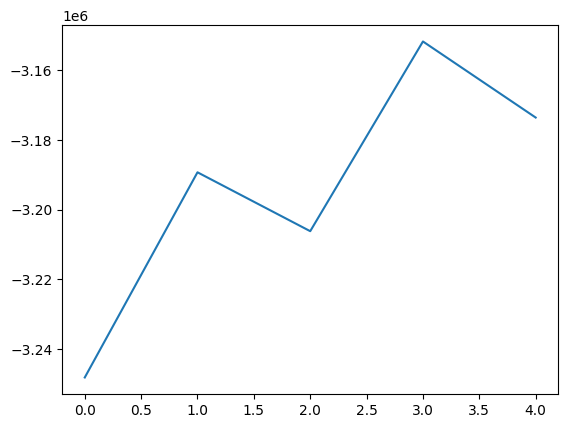

In [22]:
# Plot the training process
training_log = pd.read_csv(RL_PATH + 'monitor.csv', skiprows=1)
training_log['r'].plot()

In [23]:
env.training = False

actions, observations, electricity_consumption, excess_energy, cost_of_external_generator, rewards = ([], [], [], [], [], [])
done = False
obs = env.reset()
while not done:
        action = model.predict(obs, deterministic=True)
        obs, r, done, info = env.step([action[0][0]])

        actions.append(action[0][0][0])
        original_reward = env.get_original_reward()[0]
        original_obs = env.get_original_obs()[0]
        observations.append(original_obs)
        electricity_consumption.append(info[0]['electricity_consumption'])
        excess_energy.append(info[0]['excess_energy'])
        cost_of_external_generator.append(info[0]['cost_of_external_generator'])
        rewards.append(r)

trajectory = pd.DataFrame({
        'action': actions,
        'observations': observations,
        'electricity_consumption': electricity_consumption,
        'excess_energy': excess_energy,
        'cost_of_external_generator': cost_of_external_generator,
        'reward': rewards
    })

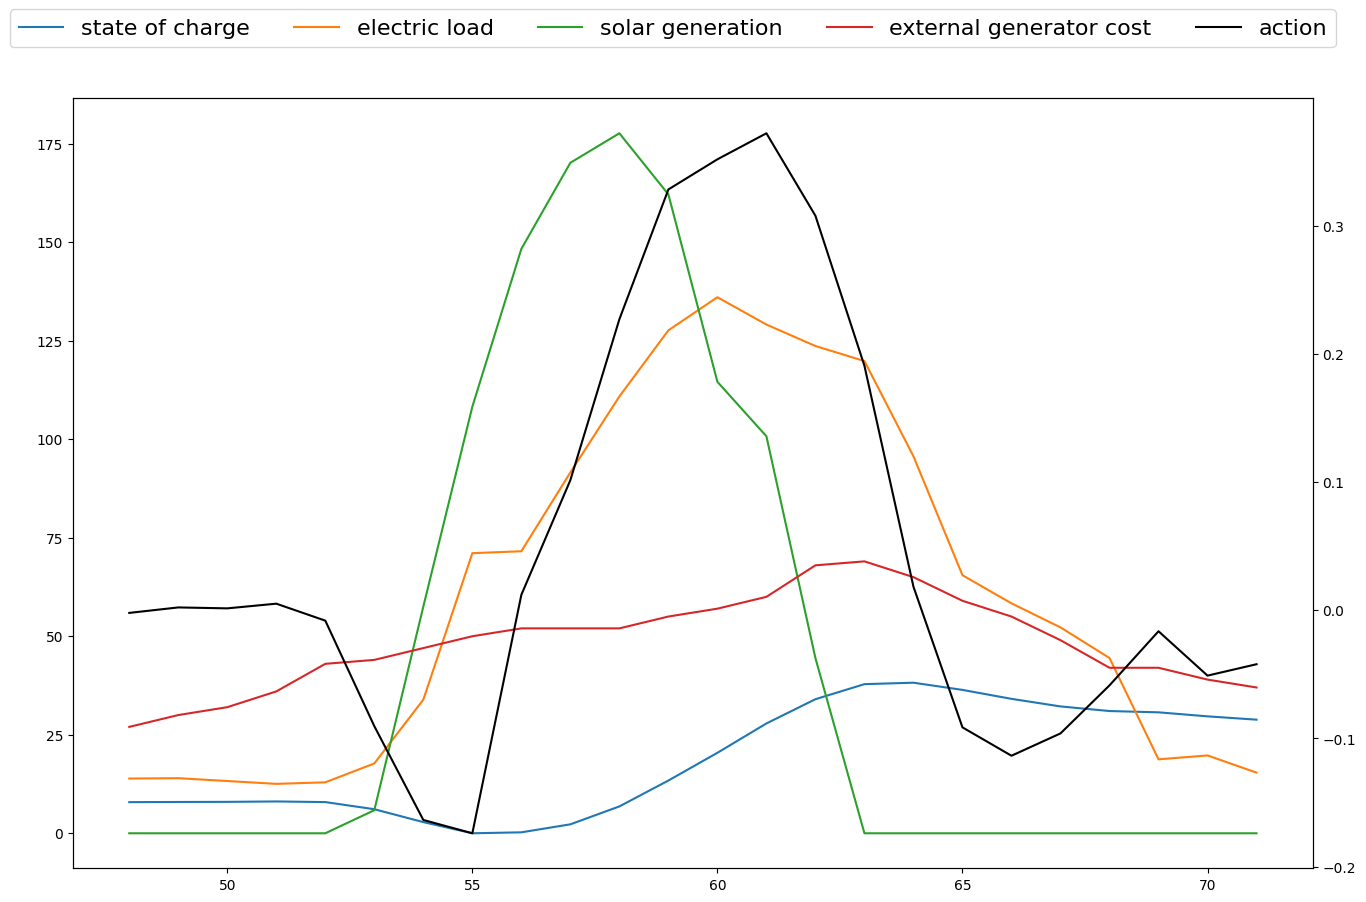

In [24]:
plot_data = trajectory[48:72]
observation_df = plot_data['observations'].apply(pd.Series)

plt.rcParams["figure.figsize"] = (16,10)

fig, ax = plt.subplots()
ax.plot(observation_df[0], label = 'state of charge')
ax.plot(observation_df[1], label = 'electric load')
ax.plot(observation_df[6], label = 'solar generation')
ax.plot(observation_df[10], label = 'external generator cost')
# ax.plot(plot_data['excess_energy'], label = 'excess energy')
# ax.plot(plot_data['electricity_consumption'], label = 'electricity consumption')

ax1 = ax.twinx()
ax1.plot(plot_data['action'], label = 'action', color = 'black')
fig.legend(bbox_to_anchor=[0.5, 0.95], loc = 'center', ncol=5, prop={'size': 16})

# Compare to Baseline

In [12]:
env.training = False

costs = []
done = False
obs = env.reset()
while not done:
    action = model.predict(obs, deterministic=True)
    obs, r, done, info = env.step([action[0][0]])
    costs.append(info[0]['cost_of_external_generator'])

total_costs = sum(costs)

In [13]:
env.training = False

baseline_costs = []
done = False
obs = env.reset()
while not done:
    # Always taking noop as action. This is the electricity demand if there would be no battery
    action = [0]
    obs, r, done, info = env.step(action)
    baseline_costs.append(info[0]['cost_of_external_generator'])

baseline_total_costs = sum(baseline_costs)

In [16]:
money_saved = baseline_total_costs - total_costs
percentage_saved = money_saved / baseline_total_costs * 100
print(f'Money saved: {money_saved} €')
print(f'Percentage saved: {percentage_saved} %')

Money saved: 157364.18928299425 €
Percentage saved: 6.7868735299098555 %


In [19]:
env.training = False

random_baseline_costs = []
done = False
obs = env.reset()
while not done:
    # Always taking random as action
    action = env.action_space.sample()
    obs, r, done, info = env.step(action)
    random_baseline_costs.append(info[0]['cost_of_external_generator'])

random_baseline_total_costs = sum(random_baseline_costs)

In [18]:
# How much money did we save by utilizing the battery?
money_saved = random_baseline_total_costs - total_costs
percentage_saved = (money_saved / random_baseline_total_costs) * 100
print('Money saved: ' + str(money_saved))
print('Percentage saved: ' + str(percentage_saved))

Money saved: 235897.78572576866
Percentage saved: 9.840601451258268
